In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr 
import scipy
import sys
sys.path.insert(1, '../scripts/')
import utils
from gtfparse import read_gtf
import mygene
import numpy as np
import scipy.stats


# Define the plotting parameters

In [2]:
# Define the settings for the plots
rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20}

# A. Number of reads per sample

In [4]:
# Extract the CCS read length for each sample
!samtools view -h ../data/transcriptomics/isoquant/sample1/ccs.bam | awk -F '\t' '{len = length($10); printf ("%5s\t%s\n", $1, len)}' > ../data/transcriptomics/isoquant/sample1/ccs_length.txt
!samtools view -h ../data/transcriptomics/isoquant/sample2/ccs.bam | awk -F '\t' '{len = length($10); printf ("%5s\t%s\n", $1, len)}' > ../data/transcriptomics/isoquant/sample2/ccs_length.txt
!samtools view -h ../data/transcriptomics/isoquant/sample3/ccs.bam | awk -F '\t' '{len = length($10); printf ("%5s\t%s\n", $1, len)}' > ../data/transcriptomics/isoquant/sample3/ccs_length.txt

In [3]:
# Load the ccs read length of each sample into a dataframe
df1 = pd.read_csv('../data/transcriptomics/isoquant/sample1/ccs_length.txt', sep = '\t', header = None, names = ['read', 'length'])
df1 = df1.iloc[3:]
df1['sample'] = 'Sample 1'

df2 = pd.read_csv('../data/transcriptomics/isoquant/sample2/ccs_length.txt', sep = '\t', header = None, names = ['read', 'length'])
df2 = df2.iloc[3:]
df2['sample'] = 'Sample 2'

df3 = pd.read_csv('../data/transcriptomics/isoquant/sample3/ccs_length.txt', sep = '\t', header = None, names = ['read', 'length'])
df3 = df3.iloc[3:]
df3['sample'] = 'Sample 3'

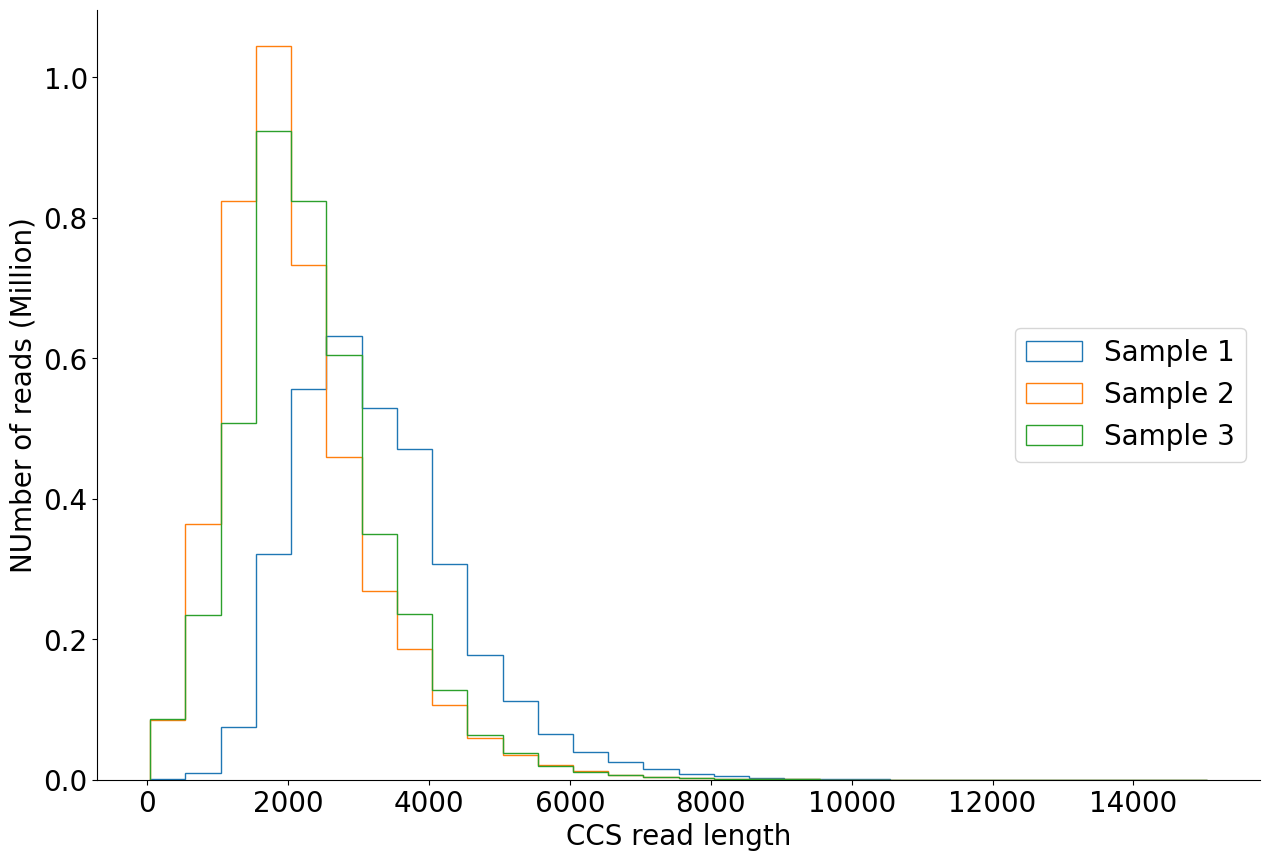

Average transcript length in sample 1:  3309.131416642464
Average transcript length in sample 2:  2153.106870308665
Average transcript length in sample 3:  2357.939415539895


In [4]:
# Create the histogram
binwidth = 500
bins=range(min(df1['length']), max(df1['length']) + binwidth, binwidth) 

def numfmt(x, pos):
    s = f'{x/1000000:,.1f}' 
    return s
yfmt = tkr.FuncFormatter(numfmt)

plt.rcParams.update(rc)
fig, ax = plt.subplots()

plt.hist(df1['length'], bins=bins, histtype = 'step')
plt.hist(df2['length'], bins=bins, histtype = 'step')
plt.hist(df3['length'], bins=bins, histtype = 'step')
plt.legend(['Sample 1', 'Sample 2', 'Sample 3'], loc = 'center right')
ax.yaxis.set_major_formatter(yfmt)
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
plt.xlabel('CCS read length')
plt.ylabel('NUmber of reads (Million)')
plt.savefig('plots/reads_per_sample.svg', dpi=300, bbox_inches='tight')
plt.show()

print('Average transcript length in sample 1: ', df1['length'].mean())
print('Average transcript length in sample 2: ', df2['length'].mean())
print('Average transcript length in sample 3: ', df3['length'].mean())

# B. Correlation of gene length with the number of isoforms

In [6]:
# Downloaded from Biomart on 24 August 2023
gene_length = pd.read_csv('../data/biomart/transcript_length.txt', sep = '\t')

# Get the longest transcript per gene
idx = gene_length.groupby(['Gene name'])['Transcript length (including UTRs and CDS)'].transform(max) == gene_length['Transcript length (including UTRs and CDS)']
longest = gene_length[idx]

# Load the isoquant transcripts
isoquant = pd.read_csv('../data/transcriptomics/isoquant/isoquant_classification.tsv', sep = '\t')

counts = isoquant.gene_symbol.value_counts() 
counts_dict = counts.to_dict()
longest['number_of_isoforms'] = longest['Gene name'].map(counts_dict)
longest = longest.dropna()
longest.head()

/tmp/ipykernel_3240790/2120523203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longest['number_of_isoforms'] = longest['Gene name'].map(counts_dict)


,Transcript length (including UTRs and CDS),Gene name,number_of_isoforms
132,4233,GRK1,4.0
137,3666,TOLLIP,2.0
155,4528,BRSK2,9.0
172,2265,KRTAP5-AS1,6.0
187,3174,MOB2,2.0


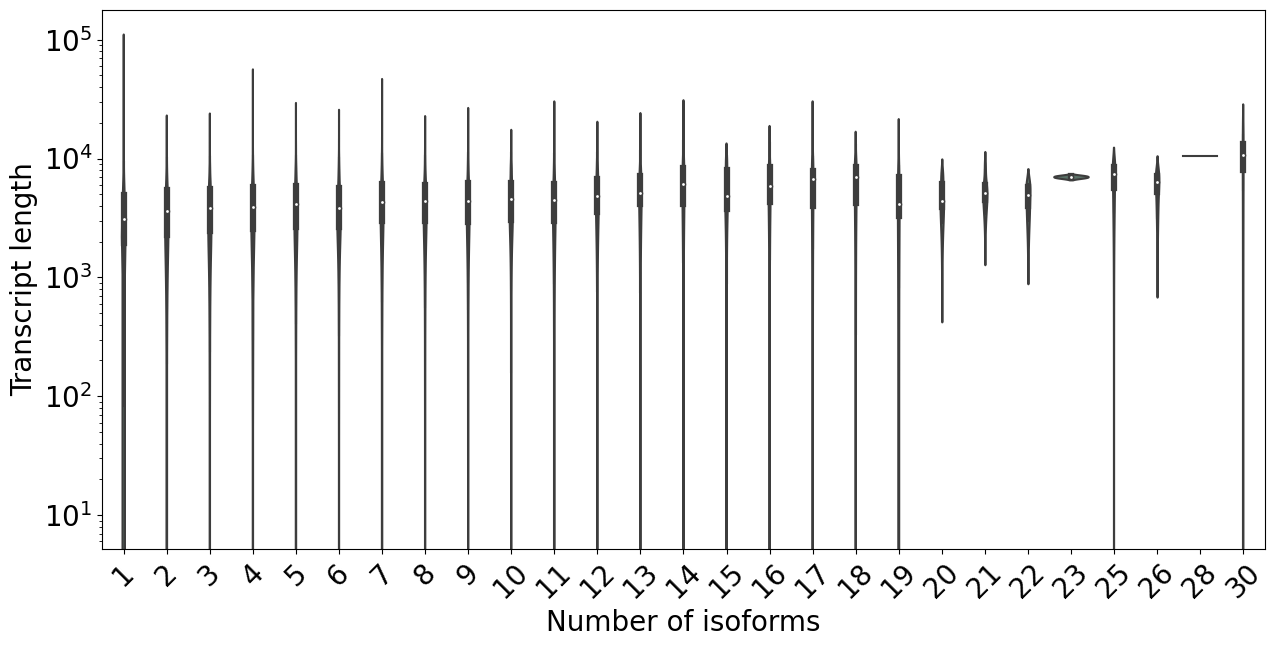

SignificanceResult(statistic=0.18651299300458576, pvalue=1.1808378885061224e-115)


In [10]:
# Filter for genes with transcripts shorter than 15kb
#longest = longest[longest['Transcript length (including UTRs and CDS)'] < 15000]

rc = {'figure.figsize':(15,7)}
plt.rcParams.update(rc)
plt.rcParams["svg.fonttype"] = "none"


#sns.lmplot(x='Transcript length (including UTRs and CDS)', y = 'number_of_isoforms', data = longest, height=5, aspect=1.5, line_kws={'color': '#cb564f'}, scatter_kws={'alpha':0.1, 's':5, 'color' : '#567568'})
sns.violinplot( x = 'number_of_isoforms', y='Transcript length (including UTRs and CDS)', data = longest, color = '#567568')

# Get unique isoforms and sort them
unique_isoforms = sorted(longest['number_of_isoforms'].unique())
plt.xticks(ticks=range(len(unique_isoforms)), labels=[int(x) for x in unique_isoforms])
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Set y-axis to start from 0
plt.yscale('log')
plt.ylabel('Transcript length')
plt.xlabel('Number of isoforms')
plt.savefig('plots/length_isoform_number_correlation.svg', dpi=300, bbox_inches='tight')
plt.show()

print(scipy.stats.spearmanr(longest['Transcript length (including UTRs and CDS)'], longest['number_of_isoforms']))

# C. Number of isoform per gene - IRD genes

/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcripts', 'transcript_id', 'similar_reference_id', 'alternatives', 'exons', 'Canonical', 'exon']
/tmp/ipykernel_1651007/2331522559.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gen

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-16277...done.
Finished.
1 input query terms found dup hits:
	[('ENSG00000249738', 2)]
499 input query terms found no hit:
	['novel_gene_chr1_393', 'novel_gene_chr1_2886', 'novel_gene_chr1_3692', 'novel_gene_chr1_4758', 'nov
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


/tmp/ipykernel_1651007/2331522559.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genes['gene_symbol'] = genes['gene_id'].replace(dict_genes)


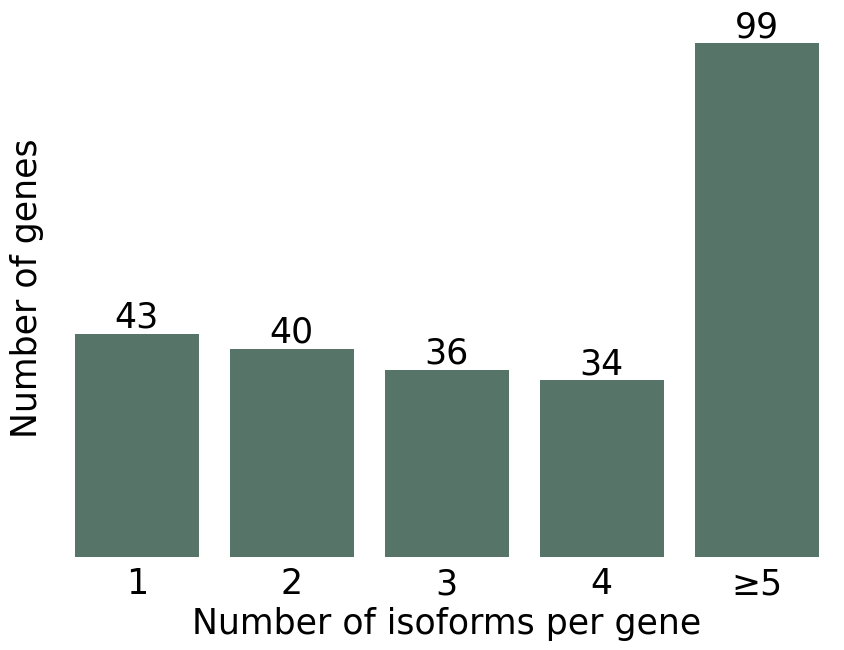

In [9]:
ird_genes = utils.ird_gene_list()

# Load the isoquant data
isoquant_gtf = read_gtf('../data/transcriptomics/isoquant/isoquant_aln.sorted.transcript_models.gtf')
genes = isoquant_gtf[isoquant_gtf['feature'] == 'gene']

# Replace the geneID with the gene symbol
mg = mygene.MyGeneInfo()
genes.gene_id = genes.gene_id.str.split('.')
genes.gene_id = genes.gene_id.str[0]
gene_symbol = mg.querymany(genes['gene_id'])
dict_genes = {}
for i in gene_symbol:
    try:
        id = i['query']
        symbol = i['symbol']
        dict_genes[id] = symbol
    except:
        id = i['query']
        dict_genes[id] = id
genes['gene_symbol'] = genes['gene_id'].replace(dict_genes)


isoforms_ird = genes[genes['gene_symbol'].isin(ird_genes)]

counts = isoforms_ird.transcripts.value_counts()
# Combine all genes with more than 10 transcripts
counts[4] = counts[4:].sum()
counts = counts[:5]

rc = {'figure.figsize':(10,7),
      'font.size' : 25}
plt.rcParams.update(rc)

p = sns.barplot(y=counts, x=['1','2','3','4','≥5'], palette=['#567568'], saturation = 1)
p.set(ylabel='Number of genes')
p.set(xlabel='Number of isoforms per gene')
# Remove y-axis labels
p.set(yticklabels=[])
# Add values to bars
p.bar_label(p.containers[0], label_type='edge', color = 'black')
# Remove x and y ticks
p.tick_params(left=False, bottom=False)
# Remove black x and y axis line
sns.despine(bottom = True, left = True)
plt.savefig('plots/number_isoforms_per_gene_ird.svg', dpi=300, bbox_inches="tight")
plt.show()

# D. Transcript classification - IRD genes

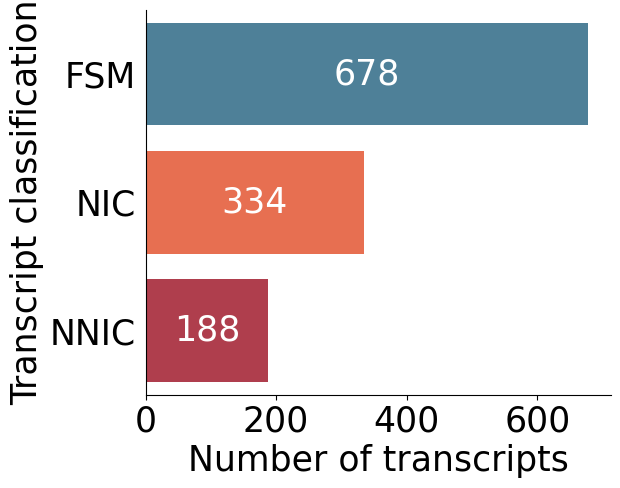

In [10]:
ird_genes = utils.ird_gene_list()

isoforms_ird = isoquant[isoquant['gene_symbol'].isin(ird_genes)]

rc = {'figure.figsize':(6,5),
      'font.size': 25}
plt.rcParams.update(rc)

p = sns.barplot(x=isoforms_ird.structural_category.value_counts().values, y=['FSM', 'NIC', 'NNIC'], palette=['#4E8098', '#E76F51', '#AF3E4D'], saturation=1)
p.set(ylabel='Transcript classification')
p.set(xlabel='Number of transcripts')
# Add data label
p.bar_label(p.containers[0], label_type='center', color = 'white')
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
# Remove x and y ticks
p.tick_params(left=False)
plt.savefig('plots/transcript_classification_ird.svg', dpi=300, bbox_inches="tight")

In [11]:
# Perform the chi-square test
isoforms_counts = isoforms_ird.structural_category.value_counts().tolist()
isoquant_counts = isoquant.structural_category.value_counts().tolist()
expected_counts = np.array(isoquant_counts) / sum(isoquant_counts) * sum(isoforms_counts)
print(scipy.stats.chisquare(isoforms_counts, expected_counts))


Power_divergenceResult(statistic=24.99066957221277, pvalue=3.744079423222493e-06)


# E. Transcript length comparison between known and novel transcripts

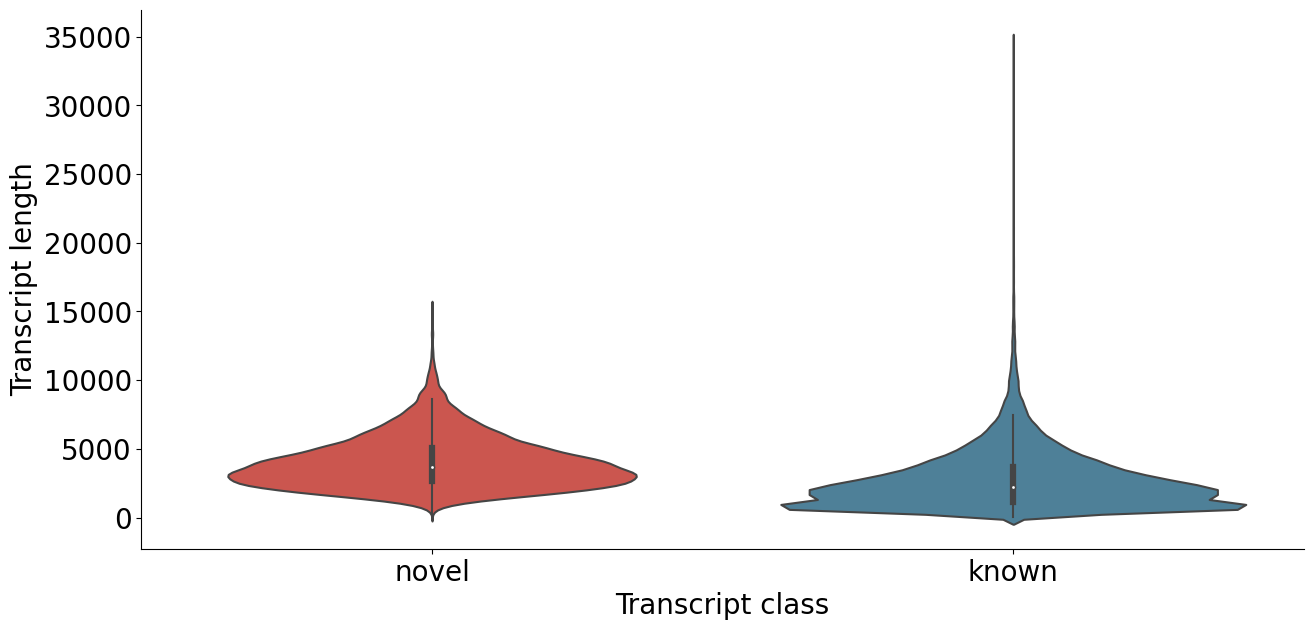

            count         mean          std    min     25%     50%     75%  \
Location                                                                     
known     36403.0  2765.562866  2211.904486   60.0  1169.0  2225.0  3677.0   
novel     22138.0  4026.794878  1874.418722  260.0  2642.0  3690.0  5050.0   

              max  
Location           
known     34626.0  
novel     15234.0  
MannwhitneyuResult(statistic=578128894.5, pvalue=0.0)
KstestResult(statistic=0.34847053010910245, pvalue=0.0, statistic_location=2399, statistic_sign=-1)


In [13]:
# Divide it into novel and known transcripts
known = isoquant[isoquant['structural_category'] == 'full-splice_match']
novel = isoquant[isoquant['structural_category'].isin(['novel_not_in_catalog', 'novel_in_catalog'])]

novel = novel.assign(Location='novel')
known = known.assign(Location='known')
cdf = pd.concat([novel, known])  

# Define the colors
colors = {'novel': '#cb564f', 'known' : '#4E8098'}

ax = sns.violinplot(x="Location", y="length", data=cdf, showfliers = True, palette = colors, saturation = 1)  
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
ax.set(xlabel='Transcript class')
ax.set(ylabel='Transcript length')
plt.savefig('plots/length_comparison.svg', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the statics
print(cdf.groupby(["Location"])['length'].describe())
print(scipy.stats.mannwhitneyu(novel.length, known.length))
print(scipy.stats.kstest(novel.length, known.length, alternative='two-sided'))

# Transcript abundance per sample

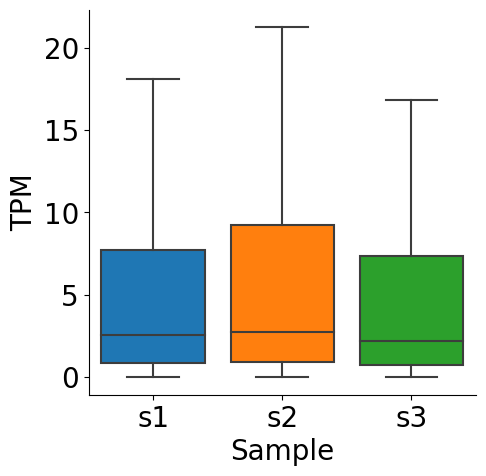

In [4]:
tpm = pd.read_csv('../data/transcriptomics/isoquant/isoquant_aln.sorted.transcript_model_grouped_tpm.tsv', sep = '\t')
tpm_long = pd.melt(tpm, value_vars=['s1', 's2', 's3'], var_name='Sample', value_name='TPM')

rc = {'figure.figsize':(5,5)}
plt.rcParams.update(rc)
plt.rcParams["svg.fonttype"] = "none"

ax = sns.boxplot(x='Sample', y='TPM', data=tpm_long, saturation=1, showfliers=False)
#plt.yscale('log')
sns.despine(bottom = False, left = False)
plt.savefig('plots/TPM_per_sample.svg', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()